In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib

In [12]:
def dice(A_binary, B_binary):
    AB = A_binary * B_binary
    DC = 2*(np.sum(AB))/(np.sum(A_binary) + np.sum(B_binary))
    return DC

# Soft Dice from https://github.com/jiwei0921/MRNet/blob/a3e016581e251d0a33817623f739489e27b2ecfc/MRNet_Code/trainer/trainer_cvpr.py#L372 
def soft_dice(image_1, image_2): 
    dice_init = 0
    for threshold in [0.1,0.3,0.5,0.7,0.9]:
        image_1_th = (image_1 >= threshold)
        image_2_th = (image_2 >= threshold)
        dice_init += dice(image_1_th, image_2_th)
        soft = dice_init / 5
    return soft 

# GED From https://github.com/soumickmj/PULASki/blob/cd6ab2c1033d7503b658fee9d82bca5402867f59/pipeline.py#L877 
def calc_confusion(labels, samples, class_ixs, loss_mask=None):
    """
    Compute confusion matrix for each class across the given arrays.
    Assumes classes are given in integer-valued encoding.
    :param labels: 4/5D array
    :param samples: 4/5D array
    :param class_ixs: integer or list of integers specifying the classes to evaluate
    :param loss_mask: 4/5D array
    :return: 2D array
    """
    try:
        assert labels.shape == samples.shape
    except:
        raise AssertionError('shape mismatch {} vs. {}'.format(labels.shape, samples.shape))

    if isinstance(class_ixs, int):
        num_classes = class_ixs
        class_ixs = range(class_ixs)
    elif isinstance(class_ixs, list):
        num_classes = len(class_ixs)
    else:
        raise TypeError('arg class_ixs needs to be int or list, not {}.'.format(type(class_ixs)))

    if loss_mask is None:
        shp = labels.shape
        # loss_mask = np.zeros(shape=(shp[0], 1, shp[2], shp[3]))
        loss_mask = np.zeros(shape=shp) #by Soumick

    conf_matrix = np.zeros(shape=(num_classes, 4), dtype=np.float32)
    for i,c in enumerate(class_ixs):

        pred_ = (samples == c).astype(np.uint8)
        labels_ = (labels == c).astype(np.uint8)

        conf_matrix[i,0] = int(((pred_ != 0) * (labels_ != 0) * (loss_mask != 1)).sum()) # TP
        conf_matrix[i,1] = int(((pred_ != 0) * (labels_ == 0) * (loss_mask != 1)).sum()) # FP
        conf_matrix[i,2] = int(((pred_ == 0) * (labels_ == 0) * (loss_mask != 1)).sum()) # TN
        conf_matrix[i,3] = int(((pred_ == 0) * (labels_ != 0) * (loss_mask != 1)).sum()) # FN

    return conf_matrix


def metrics_from_conf_matrix(conf_matrix):
    """
    Calculate IoU per class from a confusion_matrix.
    :param conf_matrix: 2D array of shape (num_classes, 4)
    :return: dict holding 1D-vectors of metrics
    """
    tps = conf_matrix[:,0]
    fps = conf_matrix[:,1]
    fns = conf_matrix[:,3]

    metrics = {}
    metrics['iou'] = np.zeros_like(tps, dtype=np.float32)

    # iterate classes
    for c in range(tps.shape[0]):
        # unless both the prediction and the ground-truth is empty, calculate a finite IoU
        if tps[c] + fps[c] + fns[c] != 0:
            metrics['iou'][c] = tps[c] / (tps[c] + fps[c] + fns[c])
        else:
            metrics['iou'][c] = np.nan

    return metrics

def calc_energy_distances(d_matrices, num_samples=None, probability_weighted=False, label_switches=None, exp_mode=5):
    """
    Calculate the energy distance for each image based on matrices holding the combinatorial distances.
    :param d_matrices: dict holding 4D arrays of shape \
    (num_images, num_modes/num_samples, num_modes/num_samples, num_classes)
    :param num_samples: integer or None
    :param probability_weighted: bool
    :param label_switches: None or dict
    :param exp_mode: integer
    :return: numpy array
    """
    d_matrices = d_matrices.copy()

    if num_samples is None:
        num_samples = d_matrices['SS'].shape[1]

    d_matrices['YS'] = d_matrices['YS'][:,:,:num_samples]
    d_matrices['SS'] = d_matrices['SS'][:,:num_samples,:num_samples]

    # perform a nanmean over the class axis so as to not factor in classes that are not present in
    # both the ground-truth mode as well as the sampled prediction
    if probability_weighted:       
        mode_stats = get_mode_statistics(label_switches, exp_modes=exp_mode)
        mode_probs = mode_stats['mode_probs']

        mean_d_YS = np.nanmean(d_matrices['YS'], axis=-1)
        mean_d_YS = np.mean(mean_d_YS, axis=2)
        mean_d_YS = mean_d_YS * mode_probs[np.newaxis, :]
        d_YS = np.sum(mean_d_YS, axis=1)

        mean_d_SS = np.nanmean(d_matrices['SS'], axis=-1)
        d_SS = np.mean(mean_d_SS, axis=(1, 2))

        mean_d_YY = np.nanmean(d_matrices['YY'], axis=-1)
        mean_d_YY = mean_d_YY * mode_probs[np.newaxis, :, np.newaxis] * mode_probs[np.newaxis, np.newaxis, :]
        d_YY = np.sum(mean_d_YY, axis=(1, 2))

    else:
        mean_d_YS = np.nanmean(d_matrices['YS'], axis=-1)
        d_YS = np.mean(mean_d_YS)#, axis=(1,2))

        mean_d_SS = np.nanmean(d_matrices['SS'], axis=-1)
        d_SS = np.mean(mean_d_SS)#, axis=(1, 2))

        mean_d_YY = np.nanmean(d_matrices['YY'], axis=-1)
        d_YY = np.nanmean(mean_d_YY)#, axis=(1, 2))

    return 2 * d_YS - d_SS - d_YY

def get_energy_distance_components(gt_seg_modes, seg_samples, eval_class_ids, ignore_mask=None):
    """
    Calculates the components for the IoU-based generalized energy distance given an array holding all segmentation
    modes and an array holding all sampled segmentations.
    :param gt_seg_modes: N-D array in format (num_modes,[...],H,W)
    :param seg_samples: N-D array in format (num_samples,[...],H,W)
    :param eval_class_ids: integer or list of integers specifying the classes to encode, if integer range() is applied
    :param ignore_mask: N-D array in format ([...],H,W)
    :return: dict
    """
    num_modes = gt_seg_modes.shape[0]
    num_samples = seg_samples.shape[0]

    if isinstance(eval_class_ids, int):
        eval_class_ids = list(range(eval_class_ids))

    d_matrix_YS = np.zeros(shape=(num_modes, num_samples, len(eval_class_ids)), dtype=np.float32)
    d_matrix_YY = np.zeros(shape=(num_modes, num_modes, len(eval_class_ids)), dtype=np.float32)
    d_matrix_SS = np.zeros(shape=(num_samples, num_samples, len(eval_class_ids)), dtype=np.float32)

    # iterate all ground-truth modes
    for mode in range(num_modes):

        ##########################################
        #   Calculate d(Y,S) = [1 - IoU(Y,S)],	 #
        #   with S ~ P_pred, Y ~ P_gt  			 #
        ##########################################

        # iterate the samples S
        for i in range(num_samples):
            conf_matrix = calc_confusion(gt_seg_modes[mode], seg_samples[i],
                                                        loss_mask=ignore_mask, class_ixs=eval_class_ids)
            iou = metrics_from_conf_matrix(conf_matrix)['iou']
            d_matrix_YS[mode, i] = 1. - iou

        ###########################################
        #   Calculate d(Y,Y') = [1 - IoU(Y,Y')],  #
        #   with Y,Y' ~ P_gt  	   				  #
        ###########################################

        # iterate the ground-truth modes Y' while exploiting the pair-wise symmetries for efficiency
        for mode_2 in range(mode, num_modes):
            conf_matrix = calc_confusion(gt_seg_modes[mode], gt_seg_modes[mode_2],
                                                        loss_mask=ignore_mask, class_ixs=eval_class_ids)
            iou = metrics_from_conf_matrix(conf_matrix)['iou']
            d_matrix_YY[mode, mode_2] = 1. - iou
            d_matrix_YY[mode_2, mode] = 1. - iou

    #########################################
    #   Calculate d(S,S') = 1 - IoU(S,S'),  #
    #   with S,S' ~ P_pred        			#
    #########################################

    # iterate all samples S
    for i in range(num_samples):
        # iterate all samples S'
        for j in range(i, num_samples):
            conf_matrix = calc_confusion(seg_samples[i], seg_samples[j],
                                                        loss_mask=ignore_mask, class_ixs=eval_class_ids)
            iou = metrics_from_conf_matrix(conf_matrix)['iou']
            d_matrix_SS[i, j] = 1. - iou
            d_matrix_SS[j, i] = 1. - iou

    return {'YS': d_matrix_YS, 'SS': d_matrix_SS, 'YY': d_matrix_YY}

################################################
###############   Contrib from Nilser   ########
################################################

def GED (image_1, image_2):
    GED = calc_energy_distances(get_energy_distance_components(np.expand_dims(image_1,axis=0), 
                                np.expand_dims(image_2,axis=0), eval_class_ids=[1])) 
    return GED

In [4]:
df=[]
for sub in range (1,6):
    path_database = "/mnt/d/Poly/ISBI_2015/training/"
    image_data = nib.load(path_database  +'training' + str(sub).zfill(2) +'/masks/'+ 'training' + str(sub).zfill(2) +'_01_soft.nii.gz')
    training_01_soft = np.array(image_data.get_fdata())

    image_data = nib.load(path_database  +'training' + str(sub).zfill(2) +'/masks/'+ 'training' + str(sub).zfill(2) +'_02_soft.nii.gz')
    training_02_soft = np.array(image_data.get_fdata())

    image_data = nib.load(path_database  +'training' + str(sub).zfill(2) +'/masks/'+ 'training' + str(sub).zfill(2) +'_03_soft.nii.gz')
    training_03_soft = np.array(image_data.get_fdata())

    image_data = nib.load(path_database  +'training' + str(sub).zfill(2) +'/masks/'+ 'training' + str(sub).zfill(2) +'_04_soft.nii.gz')
    training_04_soft = np.array(image_data.get_fdata())

    GED_1_2 = GED (training_01_soft,training_02_soft)
    soft_dice_1_2 = soft_dice (training_01_soft,training_02_soft)
    GED_1_3 = GED (training_01_soft,training_03_soft)
    soft_dice_1_3 = soft_dice (training_01_soft,training_03_soft)
    GED_1_4 = GED (training_01_soft,training_04_soft)
    soft_dice_1_4 = soft_dice (training_01_soft,training_04_soft)
    GED_2_3 = GED (training_02_soft,training_03_soft)
    soft_dice_2_3 = soft_dice (training_02_soft,training_03_soft)
    GED_2_4 = GED (training_02_soft,training_04_soft)
    soft_dice_2_4 = soft_dice (training_02_soft,training_04_soft)
    GED_3_4 = GED (training_03_soft,training_04_soft)
    soft_dice_3_4 = soft_dice (training_03_soft,training_04_soft)
    d = {'subject': sub, 'soft_dice_1_2':soft_dice_1_2, 'soft_dice_1_3':soft_dice_1_3, 'soft_dice_1_4':soft_dice_1_4, 
         'soft_dice_2_3':soft_dice_2_3, 'soft_dice_2_4':soft_dice_2_4, 'soft_dice_3_4':soft_dice_3_4,
        'GED_1_2':GED_1_2, 'GED_1_3':GED_1_3, 'GED_1_4':GED_1_4, 
         'GED_2_3':GED_2_3, 'GED_2_4':GED_2_4, 'GED_3_4':GED_3_4    }
    df.append(d)
    data=pd.DataFrame(data=df)
data

,subject,soft_dice_1_2,soft_dice_1_3,soft_dice_1_4,soft_dice_2_3,soft_dice_2_4,soft_dice_3_4,GED_1_2,GED_1_3,GED_1_4,GED_2_3,GED_2_4,GED_3_4
0,1,0.749860,0.752122,0.704453,0.899556,0.706645,0.733856,0.757907,0.763492,0.903718,0.409340,0.899654,0.838055
1,2,0.718799,0.760397,0.769972,0.833739,0.716950,0.804135,0.905504,0.759635,0.762089,0.638932,0.970217,0.650778
2,3,0.723358,0.674033,0.696857,0.701797,0.717491,0.853146,0.699197,0.855106,0.812481,0.916940,0.865044,0.424047
3,4,0.693901,0.707340,0.741147,0.755282,0.767905,0.764991,0.864209,0.805426,0.836812,0.704127,0.678993,0.658562
4,5,0.540207,0.638190,0.619788,0.679000,0.668742,0.835081,1.292886,1.085616,1.098397,1.012665,1.033399,0.590441


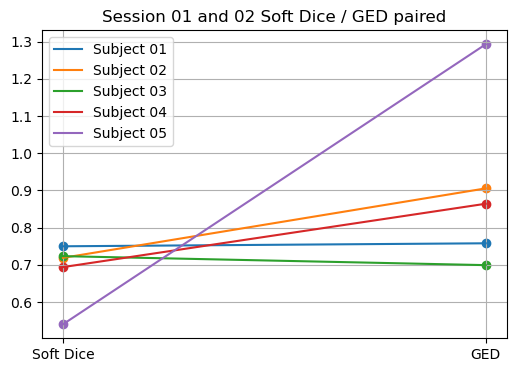

In [5]:
p1 = data.soft_dice_1_2
p2 = data.GED_1_2
pairs = list(zip(p1, p2))
subjects = [1, 2, 3, 4, 5]

plt.figure(figsize=(6, 4))
for i, pair in enumerate(pairs):

    plt.plot(("Soft Dice", "GED"), pair, label=f"Subject 0{subjects[i]}")
    plt.scatter(("Soft Dice", "GED"), pair)
plt.legend(loc="best")
plt.grid()
plt.title("Session 01 and 02 Soft Dice / GED paired")
plt.show()

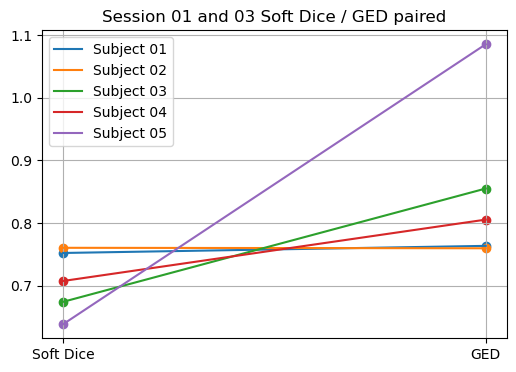

In [6]:
p1 = data.soft_dice_1_3
p2 = data.GED_1_3
pairs = list(zip(p1, p2))
subjects = [1, 2, 3, 4, 5]

plt.figure(figsize=(6, 4))
for i, pair in enumerate(pairs):

    plt.plot(("Soft Dice", "GED"), pair, label=f"Subject 0{subjects[i]}")
    plt.scatter(("Soft Dice", "GED"), pair)
plt.legend(loc="best")
plt.grid()
plt.title("Session 01 and 03 Soft Dice / GED paired")
plt.show()

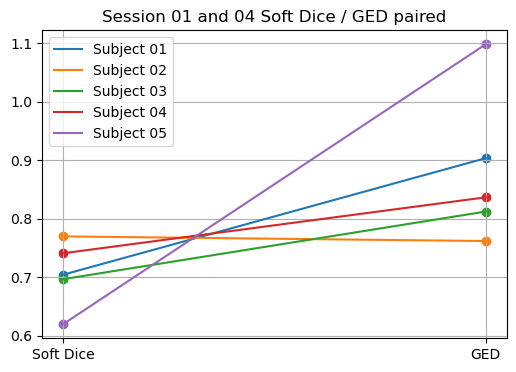

In [7]:
p1 = data.soft_dice_1_4
p2 = data.GED_1_4
pairs = list(zip(p1, p2))
subjects = [1, 2, 3, 4, 5]

plt.figure(figsize=(6, 4))
for i, pair in enumerate(pairs):

    plt.plot(("Soft Dice", "GED"), pair, label=f"Subject 0{subjects[i]}")
    plt.scatter(("Soft Dice", "GED"), pair)
plt.legend(loc="best")
plt.grid()
plt.title("Session 01 and 04 Soft Dice / GED paired")
plt.show()

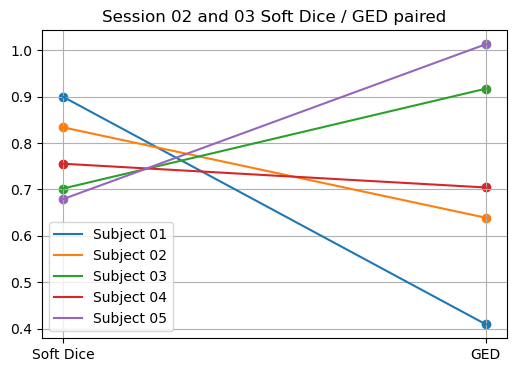

In [8]:
p1 = data.soft_dice_2_3
p2 = data.GED_2_3
pairs = list(zip(p1, p2))
subjects = [1, 2, 3, 4, 5]

plt.figure(figsize=(6, 4))
for i, pair in enumerate(pairs):

    plt.plot(("Soft Dice", "GED"), pair, label=f"Subject 0{subjects[i]}")
    plt.scatter(("Soft Dice", "GED"), pair)
plt.legend(loc="best")
plt.grid()
plt.title("Session 02 and 03 Soft Dice / GED paired")          
plt.show()

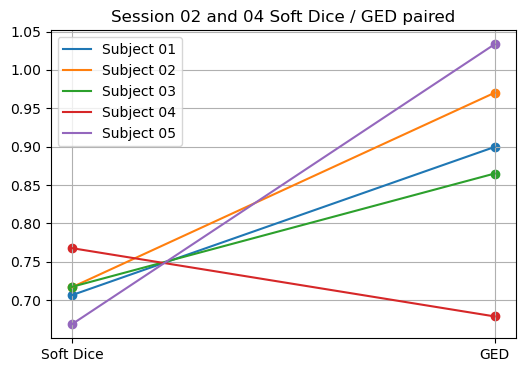

In [9]:
p1 = data.soft_dice_2_4
p2 = data.GED_2_4
pairs = list(zip(p1, p2))
subjects = [1, 2, 3, 4, 5]

plt.figure(figsize=(6, 4))
for i, pair in enumerate(pairs):

    plt.plot(("Soft Dice", "GED"), pair, label=f"Subject 0{subjects[i]}")
    plt.scatter(("Soft Dice", "GED"), pair)
plt.legend(loc="best")
plt.grid()
plt.title("Session 02 and 04 Soft Dice / GED paired")          
plt.show()

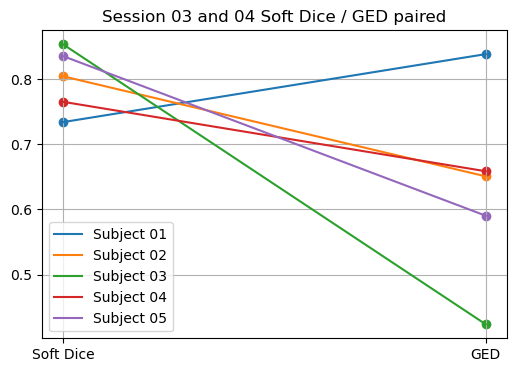

In [10]:
p1 = data.soft_dice_3_4
p2 = data.GED_3_4
pairs = list(zip(p1, p2))
subjects = [1, 2, 3, 4, 5]

plt.figure(figsize=(6, 4))
for i, pair in enumerate(pairs):

    plt.plot(("Soft Dice", "GED"), pair, label=f"Subject 0{subjects[i]}")
    plt.scatter(("Soft Dice", "GED"), pair)
plt.legend(loc="best")
plt.grid()
plt.title("Session 03 and 04 Soft Dice / GED paired")          
plt.show()